In [1]:
%load_ext autoreload
%autoreload 2

# Self-Supervised Learning

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/learn/04_self_supervised_learning.ipynb)

As we saw in the previous notebook, using pre-trained convnets gives us better data efficiency. In our example we were able to go from a 15% error rate to a 5% error rate, which is a 66% improvement, by leveragin the pre-trained weights on the Imagenet dataset, which is very different from satellite imagery. The problem is that there is no imagenet-like dataset for satellite imagery, nor pre-trained models on this data types (which is a common problem in many real world applications). However, we have available large datasets of unlabeled satellite images, so our objective will be to pre-train a convnet on unlabeled data (closer to our problem) in a self-supervised way, and then use it to fine-tune a model on our labeled data to obtain even better results.

In this example we are going to pre-train a resnet18 on the [SeCo](https://github.com/ServiceNow/seasonal-contrast) 100k RGB variant dataset using the [Barlow Twins](https://arxiv.org/abs/2103.03230) framework.

In [2]:
from convnets.datasets import SeCo 

seco = SeCo()

In [3]:
seco.data

,image
0,/fastdata/seasonal_contrast_100k/004556/202007...
1,/fastdata/seasonal_contrast_100k/004556/201911...
2,/fastdata/seasonal_contrast_100k/004556/202004...
3,/fastdata/seasonal_contrast_100k/004556/202009...
4,/fastdata/seasonal_contrast_100k/004556/202001...
...,...
99995,/fastdata/seasonal_contrast_100k/013355/201907...
99996,/fastdata/seasonal_contrast_100k/013355/201909...
99997,/fastdata/seasonal_contrast_100k/013355/202005...
99998,/fastdata/seasonal_contrast_100k/013355/202003...


In [4]:
from convnets.datasets import SSLDataset 
import albumentations as A

dataset = SSLDataset(seco.data.image.values, trans=A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.5, 1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    A.GaussianBlur(p=0.3),
    # A.Solarize(p=0.3)
]))

len(dataset)

100000

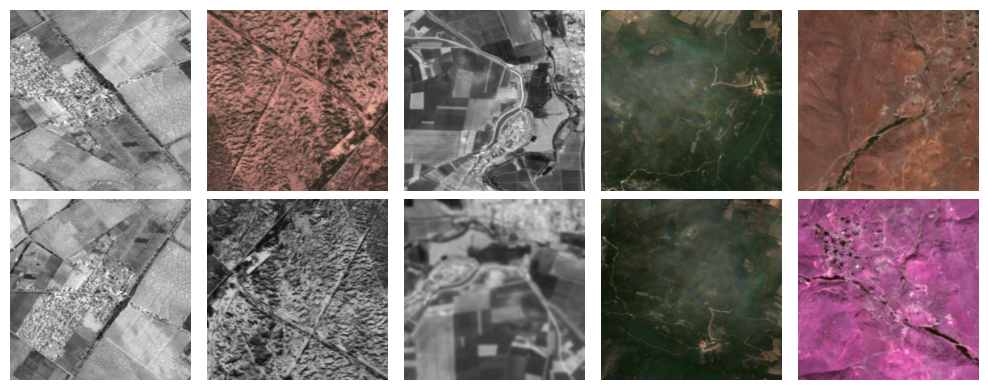

In [5]:
import random
import matplotlib.pyplot as plt
from einops import rearrange

r, c = 2, 5
plt.figure(figsize=(c*2, r*2))
for col in range(c):
    plt.subplot(r, c, col + 1)
    ix = random.randint(0, len(dataset)-1)
    im1, im2 = dataset[ix]
    plt.imshow(rearrange(im1, 'c h w -> h w c'))
    plt.axis('off')
    plt.subplot(r, c, c + col + 1)
    plt.imshow(rearrange(im2, 'c h w -> h w c'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
import torchvision
from convnets.models import BarlowTwins
import torch
from convnets.train import barlow_fit 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)

backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
model = BarlowTwins(backbone)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.03, max_lr=1e-3, total_steps=100, verbose=True)

hist = barlow_fit(model, dataloader, optimizer, scheduler, epochs=100, limit_train_batches=100)

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Adjusting learning rate of group 0 to 4.0000e-05.
Training model on cuda


Adjusting learning rate of group 0 to 5.2000e-04.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9974e-04.
Adjusting learning rate of group 0 to 9.9895e-04.
Adjusting learning rate of group 0 to 9.9764e-04.
Adjusting learning rate of group 0 to 9.9581e-04.
Adjusting learning rate of group 0 to 9.9346e-04.
Adjusting learning rate of group 0 to 9.9059e-04.
Adjusting learning rate of group 0 to 9.8721e-04.
Adjusting learning rate of group 0 to 9.8331e-04.
Adjusting learning rate of group 0 to 9.7891e-04.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e18a74e50>
Traceback (most recent call last):
  File "/home/juan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/home/juan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1444, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


Adjusting learning rate of group 0 to 9.7400e-04.
Adjusting learning rate of group 0 to 9.6860e-04.
Adjusting learning rate of group 0 to 9.6271e-04.
